# Tutorial: advection-diffusion kernels in Parcels
Adding diffusion to simulations is insightful when investigating tracers such as heat, salt or nutrients. The spread of tracers is affected by subgrid-scale processses and unresolved physics (Van Sebille et al. 2018). Also when individual water parcels are considered, diffusion can be included in ensemble particle simulations to trace the evolution of a probability distribution. This is especially important when coarse velocity fields that are not eddy-resolving are considered, since the absence of eddies can still be parameterized through eddy diffusive fluxes (Shah et al., 2017).

## Stochastic differential equations (SDEs) for particle trajectories in the presence of diffusivity
The stochastic differential equation for a particle trajectory is given by 
$$
\begin{aligned}
    d\mathbf{X}(t) &\overset{\text{Îto}}{=} (\mathbf{u} + \nabla \cdot \mathbf{K}) dt + \mathbf{V}(t, \mathbf{X})\cdot d\mathbf{W}(t), \\
    \mathbf{X}(t_0) &= \mathbf{x}_0,
\end{aligned}
$$
where $\mathbf{X}$ is the particle position vector ($\mathbf{x}_0$ being the initial position vector), $\mathbf{v}$ the velocity vector, $\mathbf{K} = \frac{1}{2} \mathbf{V} \cdot \mathbf{V}^T$ the diffusivity tensor, and $d\mathbf{W}(t)$ a Wiener increment (normally distributed with zero mean and variance $dt$). This equation is obtained through writing the advection-diffusion equation as a Fokker-Planck equation. Particle distributions obtained by solving above equation therefore satisfy the advection-diffusion equation (van Sebille et al., 2018; Shah et al., 2013). 

Generally, in three-dimensional ocean models, $\mathbf{K}$ (and therefore $\mathbf{V}$) contains off-diagional components to account for diffusion along non-flat isopycnal surfaces. Instead, here we will focus on the simpler case of diffusion in a horizontal plane, where diffusivity is specified only in the zonal and meridional direction, i.e. 
$$\mathbf{K}(x,y)=\begin{bmatrix}
K_x(x,y) & 0\\
0 & K_y(x,y)
\end{bmatrix}.$$ 

The above stochastic differential equation then becomes 

$$
\begin{align}
    dX(t) &= a_x dt + b_x dW_x(t), \quad &X(t_0) = x_0,\\
    dY(t) &= a_y dt + b_y dW_y(t), \quad &Y(t_0) = y_0,
\end{align}
$$
where $a_i = v_i + \partial_i K_i(x, y)$ is the deterministic drift term and $b_i = \sqrt{2K_i(x, y)}$ a stochastic noise term ($\partial_i$ denotes the partial derivative with respect to $i$).

## Numerical approximations of SDEs
The simplest numerical approximation of the above SDEs is obtained by replacing $dt$ by a finite time discrete step $\Delta t$ and $dW$ by a discrete increment $\Delta W$, yielding the **Euler-Maruyama (EM) scheme** (Maruyama, 1955):
$$
\begin{equation}
    X_{n+1} = X_n + a_x \Delta t + b_x \Delta W_{n, x},
\end{equation}
$$
with a similar expression for $Y$.

The next higher-order scheme is found by including extra terms from a Taylor expansion on our SDE, yielding the **Milstein scheme of order 1 (M1)**:
$$
\begin{equation}
    X_{n+1} = X_n + a_x \Delta t + b_x \Delta W_x + \frac{1}{2}b_x \partial_x b_x(\Delta W_{n, x}^2 - \Delta t),
\end{equation}
$$
which can be rewritten by explicitly writing $b_x\partial_x b_x$ as $\partial_x K_x(z)$: 
$$
\begin{equation}
    X_{n+1} = X_n + v_x \Delta t + \frac{1}{2}\partial_x K_x(\Delta W_{n, x}^2 + \Delta t) + b\Delta W_n.
\end{equation}
$$
The extra term in the M1 scheme provides extra accuracy at negligible computational cost.

The spatial derivatives in the EM and M1 schemes can be approximated by a central difference. Higher order numerical schemes (see Gräwe et al., 2011) include higher order derivates. Since Parcels uses bilinear interpolation, these higher order derivatives cannot be computed, meaning that higher order numerical schemes cannot be used.

An overview of numerical approximations for SDEs in a particle tracking setting can be found in Gräwe et al. (2011).

## The Wiener increment
The Wiener increment should be a normally distributed random variable with zero mean and a standard deviation of $\sqrt{dt}$. While such random numbers can be generated easily by Parcels (i.e. through `random.normalvariate(0, particle.dt)`), it is more efficient to draw random numbers from a uniform distribution with the same first and second moments. The central limit theorem ensures that the contribution from consecutive Wiener increments drawn from a uniform distribution quickly converges to a normal distribution, making a substitution with a uniform distribution valid for ensemble distributions. The discrete Wiener increment used by Parcels therefore reads $\Delta W = \sqrt{3\Delta t } R[-1, 1]$. Wiener increments are drawn individually for each direction.


## Using Advection-Diffusion Kernels in Parcels
The M1 and EM advection-diffusion approximations are available as `AdvectionDiffusionM1` and `AdvectionDiffusionEM` respectively. The `AdvectionDiffusionM1` kernel should be the default choice. 

The advection component of these kernels is similar to that of the Explicit Euler advection kernel (`AdvectionEE`). In case the Euler approximation is numerically unstable for the advection part, there are two advection-diffusion kernels available where the advection is approximated through a fourth-order Runge-Kutta algorithm, similar to in `AdvectionRK4`. These are available as `AdvectionRK4DiffusionM1` and `AdvectionRKDiffusionEM`. Since the diffusion part of these kernels is only accurate to first-order, these kernels are only beneficial in case of numerical instability, or if the simulation contains regimes where diffusion vanishes. 

In the special case where diffusivity is constant over the entire domain, the diffusion-only kernel `DiffusionUniformKh` can be used in combination with an advection kernel of choice. Since the diffivity here is space-independent, gradients are not calculated, increasing efficiency. The diffusion-step can in this case be computed after or before advection, thus allowing you to chain kernels using the `+` operator.

To make a central difference approximation for computing the gradient in diffusivity, a resolution for this approximation `dres` is needed. This constant is used by the advection-diffusion kernels and must be chosen and added to the FieldSet by the user (e.g. `fieldset.add_constant('dres', 0.01)`). The size of `dres` should be much smaller than the spatial resolution of the data, but within reasonable limits of machine precision to avoid numerical errors.

## Example: impermeable diffusivity profile

Let's see the `AdvectionDiffusionM1` in action and see why it's preferable over the `AdvectionDiffusionEM` kernel. To do so, we create an idealized profile with diffusivities $K_\text{zonal}$ uniform everywhere ($K_\text{zonal} = \bar{K}=0.1$) and $K_\text{meridional}$ constant in the zonal direction, while having the following profile in the meridional direction:

$$ K_\text{meridional}(y) = \bar{K}\frac{2(1+\alpha)(1+2\alpha)}{\alpha^2H^{1+1/\alpha}} \begin{cases}
y(L-2y)^{1/\alpha},\quad 0 \leq y \leq L/2,\\
(L-y)(2y-1)^{1/a},\quad H/2 \leq y \leq L,
\end{cases}$$
with $L$ being the basin length scale, $\alpha$ as a parameter determining the steepness in the gradient in the profile. This profile is similar to that used by Gräwe (2011), now used in the meridional direction for illustrative purposes.

Let's plot $K_\text{meridional}(y)$:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from datetime import timedelta
from parcels import rng as random
from parcels import (Field, FieldSet, ErrorCode, ParticleSet, Variable, JITParticle,
                     DiffusionUniformKh, AdvectionDiffusionM1, AdvectionDiffusionEM)

In [2]:
K_bar = 0.1 # Average diffusivity
alpha = 1.  # Profile steepness
L = 1.      # Basin scale
Ny = 103    # Number of grid cells in y_direction (101 +2, one level above and one below, where fields are set to zero)
dy = 1.03/Ny # Spatial resolution
y = np.linspace(-0.01, 1.01, 103) # y-coordinates for grid
y_K = np.linspace(0., 1., 101) # y-coordinates used for setting diffusivity 
beta = np.zeros(y_K.shape) # Placeholder for fraction term in K(y) formula

for yi in range(len(y_K)):
    if y_K[yi] < L/2:
        beta[yi] = y_K[yi]*np.power(L - 2*y_K[yi], 1/alpha)
    elif y_K[yi] >= L/2:
        beta[yi] = (L - y_K[yi])*np.power(2*y_K[yi] - L, 1/alpha)
Kh_meridional = 0.1*(2*(1+alpha)*(1+2*alpha))/(alpha**2*np.power(L, 1+1/alpha))*beta
Kh_meridional = np.concatenate((np.array([0]), Kh_meridional, np.array([0])))

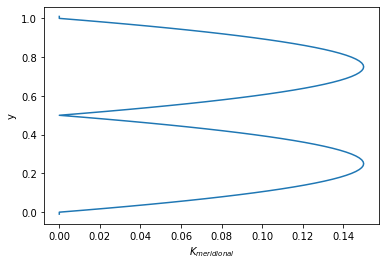

In [3]:
plt.plot(Kh_meridional, y)
plt.ylabel("y")
plt.xlabel(r"$K_{meridional}$")
plt.show()

In this profile, diffusivity drops to 0 at $y=0.5$ and at the $y=0$ and $y=1$. In the absence of advection, particles starting out in one half of the domain should remain confined to that half as they are unable to cross the points where the diffusivity drops to 0. The line $y=0.5$ should therefore provide an impermeable barrier.

Now we can put this idealized profile into a flat fieldset:

In [4]:
xdim, ydim = (1, Ny)
data = {
        'U': np.zeros((ydim, xdim)),
        'V': np.zeros((ydim, xdim))}
dims = {'lon': 1,
        'lat': np.linspace(-0.01, 1.01, ydim, dtype=np.float32)}
fieldset = FieldSet.from_data(data, dims, mesh='flat', allow_time_extrapolation = True)
fieldset.add_field(Field('Kh_meridional', np.expand_dims(Kh_meridional, axis=1), grid=fieldset.U.grid))
fieldset.add_field(Field('Kh_zonal', K_bar, grid=fieldset.U.grid))
fieldset.add_constant('dres', 0.00005)

We release 100 particles at (0, 0.75).

In [5]:
def get_test_particles():
    return ParticleSet.from_list(fieldset,
                                 pclass = JITParticle,
                                 lon = np.zeros(100),
                                 lat = np.ones(100)*0.75,
                                 time = np.zeros(100),
                                 lonlatdepth_dtype=np.float64)

Now we will simulate the advection and diffusion of the particles using the `AdvectionDiffusionM1` kernel. We run the simulation for 1 second, with a numerical timestep $\Delta t = 0.0001$s. We also write away particle locations at each timestep for plotting. Note that this will hinder a runtime comparison between kernels, since it will cause most time to be spent on I/O.

In [6]:
dt = 0.0001
testParticles = get_test_particles()
output_file = testParticles.ParticleFile(name="M1_out.nc", 
                                outputdt=timedelta(seconds=dt))
random.seed(1636) # Random seed for reproducibility
testParticles.execute(AdvectionDiffusionM1,
                      runtime=timedelta(seconds=1),
                      dt=timedelta(seconds=dt),
                      output_file=output_file,
                      verbose_progress=True,
                     )
output_file.close() # to write the output to a netCDF file, since `output_file` does not close automatically when using notebooks

INFO: Compiled random ==> /var/folders/_k/jcmdplbn0yj79g4k3g9f4nxr0000gn/T/parcels-501/parcels_random_269e31d8-ea3a-4f64-be4b-bbed47f8c7fd.so
INFO: Compiled JITParticleAdvectionDiffusionM1 ==> /var/folders/_k/jcmdplbn0yj79g4k3g9f4nxr0000gn/T/parcels-501/0aeeb5c112332d6d57b9f66f4ff9ded0_0.so
100% (1.0 of 1.0) |######################| Elapsed Time: 0:02:47 Time:  0:02:47


In [7]:
M1_out = xr.open_dataset("M1_out.nc")

We can plot the individual coordinates of the particle trajectories against time ($x$ against $t$ and $y$ against $t$) to investigate how diffusion works along each axis.

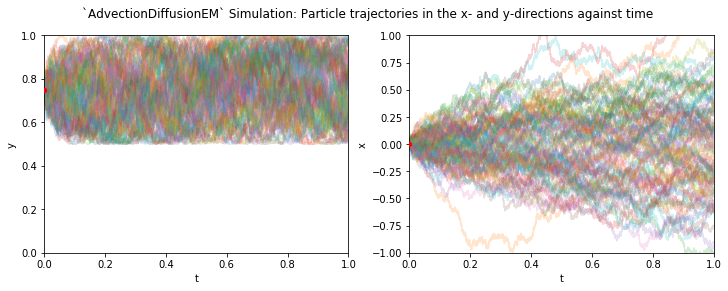

In [8]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(12)
pairs_x = np.column_stack((np.repeat(np.arange(0, 1.0002, 0.0001), 100), M1_out.lon.data.T.flatten()))
pairs_y = np.column_stack((np.repeat(np.arange(0, 1.0002, 0.0001), 100), M1_out.lat.data.T.flatten()))

ax[0].plot(np.arange(0, 1.0002, 0.0001), M1_out.lat.T, alpha=0.2)
ax[0].scatter(0, 0.75, s=20, c='r', zorder=3)
ax[0].set_xlabel("t")
ax[0].set_ylabel("y")
ax[0].set_xlim(0,1)
ax[0].set_ylim(0,1)

ax[1].plot(np.arange(0, 1.0002, 0.0001), M1_out.lon.T, alpha=0.2)
ax[1].scatter(0, 0, s=20, c='r', zorder=3)
ax[1].set_xlabel("t")
ax[1].set_ylabel("x")
ax[1].set_xlim(0,1)
ax[1].set_ylim(-1,1)

fig.suptitle("`AdvectionDiffusionEM` Simulation: Particle trajectories in the x- and y-directions against time")
plt.show()

We see that the along the meridional direction, particles remain confined to the ‘upper’ part of the domain, not crossing the impermeable barrier where the diffusivity drops to zero. In the zonal, particles follow random walks, since all terms involving gradients of the diffusivity are zero.

Now let's execute the simulation with the `AdvectionDiffusionEM` kernel instead. 

In [9]:
dt = 0.0001
testParticles = get_test_particles()
output_file = testParticles.ParticleFile(name="EM_out.nc", 
                                outputdt=timedelta(seconds=dt))
random.seed(1636) # Random seed for reproducibility
testParticles.execute(AdvectionDiffusionEM,
                      runtime=timedelta(seconds=1),
                      dt=timedelta(seconds=dt),
                      output_file=output_file,
                      verbose_progress=True,
                     )
output_file.close() # to write the output to a netCDF file, since `output_file` does not close automatically when using notebooks

INFO: Compiled JITParticleAdvectionDiffusionEM ==> /var/folders/_k/jcmdplbn0yj79g4k3g9f4nxr0000gn/T/parcels-501/21fcba8e0a047efb05f4190413face30_0.so
100% (1.0 of 1.0) |######################| Elapsed Time: 0:02:47 Time:  0:02:47


In [10]:
EM_out = xr.open_dataset("EM_out.nc")

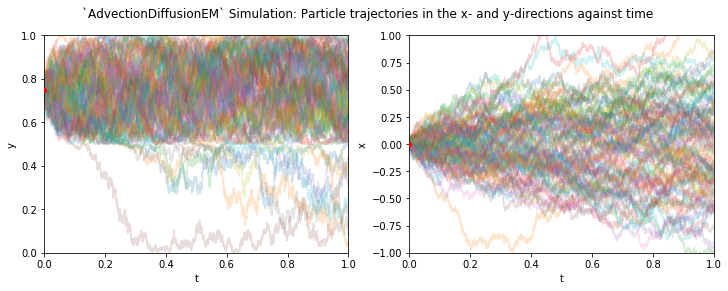

In [11]:
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(12)
pairs_x = np.column_stack((np.repeat(np.arange(0, 1.0002, 0.0001), 100), EM_out.lon.data.T.flatten()))
pairs_y = np.column_stack((np.repeat(np.arange(0, 1.0002, 0.0001), 100), EM_out.lat.data.T.flatten()))

ax[0].plot(np.arange(0, 1.0002, 0.0001), EM_out.lat.T, alpha=0.2)
ax[0].scatter(0, 0.75, s=20, c='r', zorder=3)
ax[0].set_xlabel("t")
ax[0].set_ylabel("y")
ax[0].set_xlim(0,1)
ax[0].set_ylim(0,1)

ax[1].plot(np.arange(0, 1.0002, 0.0001), EM_out.lon.T, alpha=0.2)
ax[1].scatter(0, 0, s=20, c='r', zorder=3)
ax[1].set_xlabel("t")
ax[1].set_ylabel("x")
ax[1].set_xlim(0,1)
ax[1].set_ylim(-1,1)

fig.suptitle("`AdvectionDiffusionEM` Simulation: Particle trajectories in the x- and y-directions against time")
plt.show()

The Wiener increments for both simulations are equal, as they are fixed through a random seed. As we can see, the Euler-Maruyama algorithm performs worse than the Milstein algorithm, letting particles cross the impermeable barrier at $y=0.5$. In contrast, along the zonal direction, particles follow the same random walk as in the Milstein algorithm, which is expected since the extra terms in the Milstein algorithm are zero in this case..

Lastly, we perform the same simulation with the `DiffusionUniformKh` kernel.

In [12]:
dt = 0.0001
testParticles = get_test_particles()
output_file = testParticles.ParticleFile(name="Uniform_out.nc", 
                                outputdt=timedelta(seconds=dt))
random.seed(1636) # Random seed for reproducibility
testParticles.execute(DiffusionUniformKh,
                      runtime=timedelta(seconds=1),
                      dt=timedelta(seconds=dt),
                      output_file=output_file,
                      verbose_progress=True,
                     )
output_file.close() # to write the output to a netCDF file, since `output_file` does not close automatically when using notebooks

INFO: Compiled JITParticleDiffusionUniformKh ==> /var/folders/_k/jcmdplbn0yj79g4k3g9f4nxr0000gn/T/parcels-501/5f301876ea5dba18d167d00d1efe06c7_0.so
100% (1.0 of 1.0) |######################| Elapsed Time: 0:02:49 Time:  0:02:49


In [13]:
Uniform_out = xr.open_dataset("Uniform_out.nc")

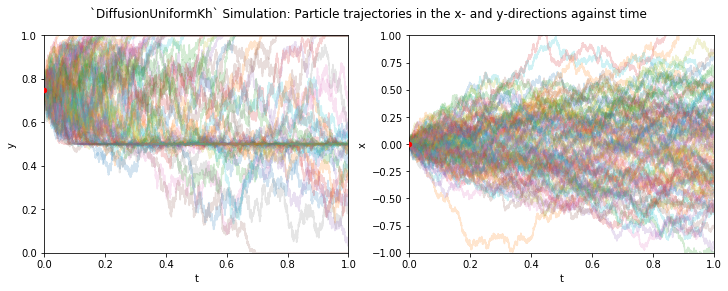

In [14]:
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(12)
pairs_x = np.column_stack((np.repeat(np.arange(0, 1.0002, 0.0001), 100), Uniform_out.lon.data.T.flatten()))
pairs_y = np.column_stack((np.repeat(np.arange(0, 1.0002, 0.0001), 100), Uniform_out.lat.data.T.flatten()))

ax[0].plot(np.arange(0, 1.0002, 0.0001), Uniform_out.lat.T, alpha=0.2)
ax[0].scatter(0, 0.75, s=20, c='r', zorder=3)
ax[0].set_xlabel("t")
ax[0].set_ylabel("y")
ax[0].set_xlim(0,1)
ax[0].set_ylim(0,1)

ax[1].plot(np.arange(0, 1.0002, 0.0001), Uniform_out.lon.T, alpha=0.2)
ax[1].scatter(0, 0, s=20, c='r', zorder=3)
ax[1].set_xlabel("t")
ax[1].set_ylabel("x")
ax[1].set_xlim(0,1)
ax[1].set_ylim(-1,1)

fig.suptitle("`DiffusionUniformKh` Simulation: Particle trajectories in the x- and y-directions against time")
plt.show()

We clearly see that in the meridional direction, particles are not able to leave the areas with a low diffusivity, accumulating on the impermeable boundaries. In the zonal direction, results are equal to those of the other two kernels. When fields have a uniform diffusivity, this kernel is the most efficient since it does not execute the interpolation steps needed for computing gradients in the diffusivity field.

#### References

Gräwe, U. (2011). “Implementation of high-order particle-tracking schemes in a water column model.” *Ocean Modelling*, 36(1), 80–89. https://doi.org/10.1016/j.ocemod.2010.10.002

Gräwe, Deleersnijder, Shah & Heemink (2012). “Why the Euler scheme in particle tracking is not enough: The shallow-sea pycnocline test case.” *Ocean Dynamics*, 62(4), 501–514. https://doi.org/10.1007/s10236-012-0523-y

Maruyama, G. (1955). “Continuous Markov processes and stochastic equations.” *Rendiconti del Circolo Matematico di Palermo*, 4(1), 48.

van Sebille et al. (2018). “Lagrangian ocean analysis: Fundamentals and practices.” *Ocean Modelling*, 121, 49–75. https://doi.org/10.1016/j.ocemod.2017.11.008

Shah, S. H. A. M., Heemink, A. W., Gräwe, U., & Deleersnijder, E. (2013). “Adaptive time stepping algorithm for Lagrangian transport models: Theory and idealised test cases.” *Ocean Modelling*, 68, 9–21. https://doi.org/10.1016/j.ocemod.2013.04.001

Shah, Primeau, Deleersnijder & Heemink (2017). “Tracing the Ventilation Pathways of the Deep North Pacific Ocean Using Lagrangian Particles and Eulerian Tracers.” *Journal of Physical Oceanography*, 47(6), 1261–1280. https://doi.org/10.1175/JPO-D-16-0098.1